# Part 3 ‑ Predictive modeling
Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?

In [1]:
import json
from pandas.io.json import json_normalize
import pandas as pd
import numpy
import h2o
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc

## 1.Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

In [2]:
with open('ultimate_data_challenge.json') as logins_file:
    logins_string = json.load(logins_file)
    user_data_df = json_normalize(logins_string)

In [3]:
user_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Two points become evident when looking at the above. Three columns have null values and that signup_date and last_trip_date are not in datetime format. Let's convert signup_date and last_trip_date to datetime format.

In [4]:
user_data_df['signup_date'] = pd.to_datetime(user_data_df['signup_date'])
user_data_df['last_trip_date'] = pd.to_datetime(user_data_df['last_trip_date'])

In [5]:
user_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null datetime64[ns]
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


Now normally I would say let's deal with the columns with null values. However a couple of weeks ago I attended a meetup where Corinne Horn presented an algorithm called GLRM (Generalized Low Rank Models). In a nutshell this is a model that can be used to reduce the dimensionality of a dataset and help determine which features are important (similar to what PCA does) but your dataset can be heterogeneous (whereas PCA is applied on a data set with numeric variables). Plus with GLRM you don't need to deal with the issue of missing data/null values because model predicts the value of missing data. In other words GLRM among other things does feature engineering, dimentionality reduction and prediction all at the same time. Pretty cool! Now in this part we need to find important features with regard to predicting a certain column in the dataset and the dataset is heterogeneous and contains missing values. So you can imagine this reminded me about the Meetup I attended and I thougt I'd try out GLRM. Finally the paper for GLRM is authored by, among others, Corinne Horn. https://web.stanford.edu/~boyd/papers/pdf/glrm.pdf 

OK, based on the above anecdoe let us not do anything with the null values right now.

For now do NOT replace null values with mean

In [6]:
#user_data_df['avg_rating_of_driver'].fillna(user_data_df['avg_rating_of_driver'].mean(), inplace=True)
#user_data_df['avg_rating_by_driver'].fillna(user_data_df['avg_rating_by_driver'].mean(), inplace=True)
user_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null datetime64[ns]
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


Now we can define the retained column by checking if a user had a trip in the past 30 days. The issue is that the date that the data was pulled is not mentioned so the best we can do is to assume that the date the data was pulled is the same as the last date that a user travelled. Therefore let us look at the last_trip_date column of the dataset 

In [7]:
user_data_df['last_trip_date'].describe()

count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

As June is 30 days we will consider a user to be active/retained if that user had a trip in June 2014 or July 2014 ( need to include boundry case 2014-07-01 00:00:00 ).

In [8]:
retained = user_data_df['last_trip_date'].dt.month >= 6
perc_ret = len(numpy.where(retained == True)[0]) / len(retained) * 100  
print("{0:2f}% of the customers were retained".format(perc_ret))

37.608000% of the customers were retained


## 2.Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

GLRM is packaged in H2O which means we need to start H2O

In [9]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.211-b12, mixed mode)
  Starting server from C:\Users\farbo\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\farbo\AppData\Local\Temp\tmpykpye5d0
  JVM stdout: C:\Users\farbo\AppData\Local\Temp\tmpykpye5d0\h2o_farbo_started_from_python.out
  JVM stderr: C:\Users\farbo\AppData\Local\Temp\tmpykpye5d0\h2o_farbo_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,04 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.4
H2O cluster version age:,8 days
H2O cluster name:,H2O_from_python_farbo_50kux9
H2O cluster total nodes:,1
H2O cluster free memory:,1.745 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [10]:
h2o.remove_all()

Let's convert a Pandas dataframe to an H2OFrame and inspect its structure

In [11]:
hf = h2o.H2OFrame(user_data_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [12]:
hf.describe()

Rows:50000
Cols:12




,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
type,enum,int,time,real,real,time,enum,real,enum,real,real,real
mins,,0.0,1388534400000.0,1.0,1.0,1388534400000.0,,0.0,,0.0,0.0,1.0
mean,,2.2781999999999933,1389877460352.0051,4.601559291274639,1.0747638000000042,1397894524991.9963,,8.849535999999949,,60.926083999999875,5.7968266000000295,4.7781581959477215
maxs,,125.0,1391126400000.0,5.0,8.0,1404172800000.0,,100.0,,100.0,160.96,5.0
sigma,,3.7926840692376396,756364650.5215206,0.6173384560411357,0.22233600894946665,5332520288.309393,,19.958810898131023,,37.08150340510531,5.707356703233395,0.4466517934656203
zeros,,15390,0,0,0,0,,34409,,9203,150,0
missing,0,0,0,8122,0,0,0,0,0,0,0,201
0,King's Landing,4.0,2014-01-25 00:00:00,4.7,1.1,2014-06-17 00:00:00,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0.0,2014-01-29 00:00:00,5.0,1.0,2014-05-05 00:00:00,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3.0,2014-01-06 00:00:00,4.3,1.0,2014-01-07 00:00:00,iPhone,0.0,False,100.0,0.77,5.0


Now let's train the GLRM model. We don't need to set asside separate predictors and responses. We just pass the entire dataset (the labels are just like any other column) to the model and it will predict any missing values in the dataset. Therefore during testing you just need to delete the data in the response column ( i.e. retained ) and send the everything else to the model for inference. Another point to mention is that there's no need to include a 'retained' column as 'retained' is defined using 'last_trip_date' and inclusion of the 'retained' column would just add a highly co-related feature to our model and would not be giving the model any extra useful information. 

In [13]:
train, test = hf.split_frame(ratios=[0.7], seed=1234)

In [14]:
model = H2OGeneralizedLowRankEstimator(k=4, init="svd", svd_method="power", loss="quadratic"
                                       , regularization_x="l2", regularization_y="l2", max_iterations=2000, gamma_x=3
                                       , gamma_y=10, impute_original=True, score_each_iteration=True, transform="normalize"
                                       , min_step_size=1e-4, loss_by_col=['categorical','categorical','logistic']
                                       , loss_by_col_idx=[0,6,8])

In [15]:
model.train(x=hf.columns, training_frame=train)

glrm Model Build progress: |██████████████████████████████████████████████| 100%


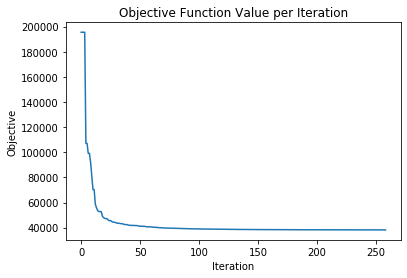

In [16]:
model_score = model.score_history()
plt.xlabel("Iteration")
plt.ylabel("Objective")
plt.title("Objective Function Value per Iteration")
plt.plot(model_score["iterations"], model_score["objective"])
plt.show()

For prediction it is important to replace all values in 'last_trip_date' with NaN so the model can impute these values.

In [17]:
new_test = h2o.deep_copy(test, 'new_test')
new_test["last_trip_date"] = numpy.NaN
pred = model.predict(new_test)

pred['reconstr_retained'] = pred['reconstr_last_trip_date'].month() >= 6
pred['reconstr_retained'] = pred['reconstr_retained'].asfactor()

test['retained'] = test['last_trip_date'].month() >= 6
test['retained'] = test['retained'].asfactor()

glrm prediction progress: |███████████████████████████████████████████████| 100%


[[8628  603]
 [4532 1184]]
0.6564527998929551
              precision    recall  f1-score   support

           0       0.66      0.93      0.77      9231
           1       0.66      0.21      0.32      5716

    accuracy                           0.66     14947
   macro avg       0.66      0.57      0.54     14947
weighted avg       0.66      0.66      0.60     14947



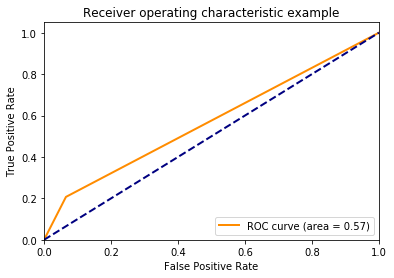

In [18]:
print(confusion_matrix(test.as_data_frame()['retained'], pred.as_data_frame()['reconstr_retained']))
print(accuracy_score(test.as_data_frame()['retained'], pred.as_data_frame()['reconstr_retained']))
print(classification_report(test.as_data_frame()['retained'], pred.as_data_frame()['reconstr_retained']))
fpr, tpr, thresholds = roc_curve(test.as_data_frame()['retained'], pred.as_data_frame()['reconstr_retained'])
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

We can see that the accuracy is 66%.

Now we need to figure out what feature are of more importance to the model.

In [19]:
ultimate_y = model._model_json["output"]["archetypes"]
print(ultimate_y)


Archetypes: 

,,cityastapor,citykings_landing,citywinterfell,phone,phoneandroid,phoneiphone,ultimate_black_user,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
0,Arch1,0.774820,-7.234691,6.610319,-7.410742,-13.768595,12.773547,22.263740,0.057067,-0.030042,-0.040611,-0.036692,0.919261,-0.237702,0.221311,0.0,-0.019209
1,Arch2,9.612615,10.289474,-24.755049,-0.618678,-15.190199,13.618586,-2.312690,-0.004161,0.102554,0.113653,0.020810,0.583216,0.194751,0.013452,0.0,0.100998
2,Arch3,-21.067964,3.365222,9.338607,-5.331094,-16.448362,14.327760,-15.204134,0.013674,-0.030803,-0.034052,0.009307,0.524234,0.066410,-0.055019,0.0,-0.028417
3,Arch4,-12.504746,20.307574,-4.003358,11.211960,3.917381,-2.828204,18.670600,0.036308,-0.000643,0.017723,-0.020724,0.886196,-0.095419,0.183155,0.0,0.013285


In [20]:
model._model_json["output"]["importance"]


Importance of components: 

,,pc1,pc2,pc3,pc4
0,Standard deviation,1.084103,0.997553,0.821846,0.755812
1,Proportion of Variance,0.343943,0.291217,0.197664,0.167176
2,Cumulative Proportion,0.343943,0.635161,0.832824,1.000000


From the above we can see that the first three principle component ( i.e. Archetypes ) cumulatively explain 83% of the variance of the dataset. Let's look at what features highly contribute positively or negatively to the Archetypes. 

In [21]:
for rowi in range(len(ultimate_y.as_data_frame().index)):
    print(ultimate_y.as_data_frame().iloc[rowi,1:].sort_values(ascending=False))
    print("\n")

ultimate_black_user         22.2637
phoneiphone                 12.7735
citywinterfell              6.61032
last_trip_date             0.919261
cityastapor                 0.77482
weekday_pct                0.221311
trips_in_first_30_days    0.0570668
avg_dist                          0
avg_rating_by_driver     -0.0192087
signup_date              -0.0300422
avg_surge                -0.0366918
avg_rating_of_driver     -0.0406105
surge_pct                 -0.237702
citykings_landing          -7.23469
phone                      -7.41074
phoneandroid               -13.7686
Name: 0, dtype: object


phoneiphone                  13.6186
citykings_landing            10.2895
cityastapor                  9.61262
last_trip_date              0.583216
surge_pct                   0.194751
avg_rating_of_driver        0.113653
signup_date                 0.102554
avg_rating_by_driver        0.100998
avg_surge                  0.0208103
weekday_pct                0.0134516
avg_dist                     

It appears that being an Ultimate Black customer, type of phone and sign up city have the highest contribution to the Archetypes. 

The take away is that based on the above I would use the columns ultimate_black_user, city, phone to predict whether a customer will be retained in the future.

As an alternative we could have used a different estimator to do the prediction.

In [22]:
h2o.cluster().shutdown()

H2O session _sid_815e closed.


## Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

Ultimate Inc. could research ways in which it can encourge customers to take an Ultimate Black in their first 30 days. 